# Emerging topics final code - Full (new code cleaning)

In [120]:
import pandas as pd
pd.set_option('display.max_columns', 50)

import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib
import gensim
import time

from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression as lm

import matplotlib.collections as mcol
from matplotlib.legend_handler import HandlerLineCollection, HandlerTuple
from matplotlib.lines import Line2D

import seaborn as sns
import os

from gensim.models.coherencemodel import CoherenceModel

import statsmodels.api as sm

## Data ingestion

In [121]:
# full corpus
df = pd.read_pickle("/project/biocomplexity/sdad/projects_data/ncses/prd/Tech-Report/FR_meta_and_final_tokens_21SEPT14.pkl")

In [122]:
df.head()

,original index,PROJECT_ID,ABSTRACT,FY,PROJECT_TERMS,PROJECT_TITLE,DEPARTMENT,AGENCY,IC_CENTER,PROJECT_NUMBER,PROJECT_START_DATE,PROJECT_END_DATE,CONTACT_PI_PROJECT_LEADER,OTHER_PIS,CONGRESSIONAL_DISTRICT,DUNS_NUMBER,ORGANIZATION_NAME,ORGANIZATION_CITY,ORGANIZATION_STATE,ORGANIZATION_ZIP,ORGANIZATION_COUNTRY,BUDGET_START_DATE,BUDGET_END_DATE,CFDA_CODE,FY.y,FY_TOTAL_COST,FY_TOTAL_COST_SUB_PROJECTS,ORG_COUNT,PI_COUNT,final_tokens
0,0,89996,"This is a project to explore Game-based, Metap...",2008,Achievement; analog; base; Cognitive Science; ...,RUI: CYGAMES: CYBER-ENABLED TEACHING AND LEARN...,NSF,NSF,NaN,0814512,9/15/2008,8/31/2012,"REESE, DEBBIE D","CARTER, BEVERLY; WOOD, CHARLES; HITT, BEN",01,068719400,WHEELING JESUIT UNIVERSITY,WHEELING,WV,26003-6243,UNITED STATES,NaN,NaN,47.076,2008,1999467.0,NaN,1,1,"[project, explore, game, base, metaphor, enhan..."
1,1,89997,Institution: Franklin Institute Science Museum...,2008,Active Learning; Child; Computer software; des...,ARIEL - AUGMENTED REALITY FOR INTERPRETIVE AND...,NSF,NSF,NaN,0741659,9/15/2008,8/31/2012,"SNYDER, STEVEN","ELINICH, KAREN; YOON, SUSAN",02,001741859,FRANKLIN INSTITUTE,PHILADELPHIA,PA,19103-1115,UNITED STATES,NaN,NaN,47.076,2008,1799699.0,NaN,1,1,"[institution, franklin_institute, science, mus..."
2,2,89998,Through programs (including small group conver...,2008,Address; Age; Birth; Brain; Caregivers; Child;...,BRIGHTER FUTURES: PUBLIC DELIBERATION ABOUT TH...,NSF,NSF,NaN,0813522,9/15/2008,8/31/2011,"FINK, LAURIE KLEINBAUM","CADIGAN, KAREN; ELLENBOGEN, KIRSTEN",04,061451670,SCIENCE MUSEUM OF MINNESOTA,SAINT PAUL,MN,55102-1202,UNITED STATES,NaN,NaN,47.076,2008,1505858.0,NaN,1,1,"[program, small, group, conversation, citizen,..."
3,3,89999,In partnership with the American Chemical Soci...,2008,Advanced Development; American; Chemicals; Che...,FOSTERING US-INTERNATIONAL COLLABORATIVE PARTN...,NSF,NSF,NaN,0838627,8/1/2008,12/31/2010,"JOST, JOHN W","MILLER, BRADLEY; BOWMAN, KATHERINE",04,009059242,INTERNATIONAL UNION OF PURE AND APPLIED CHEMISTRY,DURHAM,NC,27709-3757,UNITED STATES,NaN,NaN,47.049,2008,51000.0,NaN,1,1,"[partnership, american, chemical, society, acs..."
4,5,90001,The Center for Molecular Interfacing (CMI) wil...,2008,Address; Architecture; Carbon Nanotubes; Catal...,CCI PHASE I: CENTER FOR MOLECULAR INTERFACING,NSF,NSF,NaN,0847926,10/1/2008,9/30/2011,"ABRUNA, HECTOR D",NaN,22,872612445,CORNELL UNIVERSITY ITHACA,ITHACA,NY,14850-2820,UNITED STATES,NaN,NaN,47.049,2008,1519821.0,NaN,1,1,"[center, molecular, interfacing, cmi, enable, ..."


In [123]:
# input needed for LDA, NMF (all from Scikit-Learn) is one string per document (not a list of strings)

text = []
docs = df["final_tokens"]

for abstract in docs:
    text.append(" ".join(abstract))

In [124]:
def createLDAvars(docs):

    # Create the variables needed for LDA from df[final_frqwds_removed]: dictionary (id2word), corpus
    
    # Create Dictionary
    id2word = gensim.corpora.Dictionary(docs)

    #Filter words to only those found in at least a set number of documents (min_appearances)
    id2word.filter_extremes(no_below=20, no_above=0.6)
    
    # filter out stop words - "use" already filtered out by previous line
    id2word.filter_tokens(bad_ids=[id2word.token2id['research'], id2word.token2id['study'], \
                               id2word.token2id['project']])

    return id2word

In [125]:
id2word = createLDAvars(docs)

## Functions needed for all models

In [126]:
# Function to format topics as a "list of list of strings".
# Needed for topic coherence function in Gensim

# function modified from https://nlpforhackers.io/topic-modeling/

def list_topics(topic_term_dist, vectorizer, top_n=10):

    #input. top_n: how many words to list per topic.  If -1, then list all words.
       
    topic_words = []
    
    for idx, topic in enumerate(topic_term_dist):  # loop through each row of H.  idx = row index.  topic = actual row
            
        if top_n == -1:   
            topic_words.append([vectorizer.get_feature_names()[i] for i in topic.argsort()[::-1]])
        else:
            topic_words.append([vectorizer.get_feature_names()[i] for i in topic.argsort()[:-top_n - 1:-1]])
        
    return topic_words

In [127]:
def str_topics(topic_term_mat, vectorizer, top_n=10):

    #input. top_n: how many words to list per topic.  If -1, then list all words.
       
    topic_words = []
    
    for idx, topic in enumerate(topic_term_mat):  # loop through each row of H.  idx = row index.  topic = actual row
            
        if top_n == -1:   
            topic_words.append([vectorizer.get_feature_names()[i] for i in topic.argsort()[::-1]])
        else:
            topic_words.append([vectorizer.get_feature_names()[i] for i in topic.argsort()[:-top_n - 1:-1]])
    
    str_wds = []
    
    for wds in topic_words:
        str_wds.append(", ".join(wds))    
    
    return str_wds 

## NMF
- 50 topics, random state = ?

In [128]:
stop_wds = ['research', 'study', 'project']  # use will be eliminated by max_df

In [129]:
# construct term document matrix
tfidf_vectorizer = TfidfVectorizer(max_df=0.6, min_df=20, lowercase=False, stop_words=stop_wds)
tf_idf = tfidf_vectorizer.fit_transform(text)

In [130]:
# first time topic model run
#num_topics = 100

#nmf_model = NMF(n_components = num_topics, random_state = 1)
#doc_topic = nmf_model.fit_transform(tf_idf)
#topic_term = nmf_model.components_

In [131]:
#with open("/project/biocomplexity/sdad/projects_data/ncses/prd/nmf_full_100.pkl","wb") as f:
#    pickle.dump((doc_topic, topic_term), f)

In [132]:
# read in fit topic model
num_topics = 50            # model=50, 100, 150, 200.

with open("/project/biocomplexity/sdad/projects_data/ncses/prd/Tech-Report/nmf_full_"+str(num_topics)+".pkl", "rb") as f:
    res = pickle.load(f)
    
doc_topic = res[0]
topic_term = res[1]

In [133]:
topics = list_topics(topic_term, tfidf_vectorizer, top_n = 10)

In [134]:
# calculate coherence
#cm = CoherenceModel(topics = topics,
#                    #corpus = corpus,
#                    dictionary = id2word,
#                    texts = docs, 
#                    coherence = 'c_v', 
#                    processes = 8)

## Emerging topics

In [135]:
# Extract Year from PROJECT_START_DATE

def getYear(a):   
    a = str(a)
    if a.find("/"):
        splitdate = a.split("/")
        if len(splitdate) == 3:
            a = splitdate[2]
        else:
            a = splitdate[0]
    year = str(a)
    return year

df['START_YEAR'] = df['PROJECT_START_DATE'].apply(getYear)

In [136]:
# add start year to doc topic matrix
topic_frame = pd.DataFrame(doc_topic, columns=["Topic"+" "+str(i) for i in range(num_topics)])
topic_frame["START_YEAR"] = df["START_YEAR"]

#### compute count of projects with weight > 0 for each topic

In [137]:
topic_proj_count = topic_frame.copy()

In [138]:
# count number of docs with weight > 0
topic_count_bool = (topic_proj_count.iloc[:,0:num_topics] > 0)
topic_count_bool["START_YEAR"] = topic_proj_count["START_YEAR"]

In [139]:
# count number of docs with weight > 0 BY YEAR
topic_counts = topic_count_bool.groupby("START_YEAR").sum().reset_index()
topic_counts["START_YEAR"] = topic_counts["START_YEAR"].astype(int)

In [140]:
# get docs between 2010 and 2019
end_year = 2019
topic_counts_filt = topic_counts[topic_counts["START_YEAR"] > 2009] 
#topic_counts_filt = topic_counts_filt[topic_counts_filt["START_YEAR"] < 2020]
topic_counts_filt = topic_counts_filt[topic_counts_filt["START_YEAR"] < end_year]

In [141]:
n_by_topic = topic_counts_filt.sum()[1:]

In [142]:
len(n_by_topic)

50

#### calculate mean topic weight by year and standard errors on means

In [143]:
topic_frame_se = topic_frame.groupby("START_YEAR").sem().reset_index()
topic_frame_se = topic_frame_se.sort_values(by = "START_YEAR")
topic_frame_se["START_YEAR"] = topic_frame_se["START_YEAR"].astype(int)

topic_wts_se_2010_2019 = topic_frame_se[topic_frame_se["START_YEAR"] > 2009] 
#topic_wts_se_2010_2019 = topic_wts_se_2010_2019[topic_wts_se_2010_2019["START_YEAR"] < 2020]
topic_wts_se_2010_2019 = topic_wts_se_2010_2019[topic_wts_se_2010_2019["START_YEAR"] < end_year]

In [144]:
topic_frame = topic_frame.groupby("START_YEAR").mean().reset_index()
topic_frame = topic_frame.sort_values(by = "START_YEAR")
topic_frame["START_YEAR"] = topic_frame["START_YEAR"].astype(int)

In [145]:
# filter topic_frame for years 2010 - 2019

topic_wts_2010_2019 = topic_frame[topic_frame["START_YEAR"] > 2009] 
#topic_wts_2010_2019 = topic_wts_2010_2019[topic_wts_2010_2019["START_YEAR"] < 2020] 
topic_wts_2010_2019 = topic_wts_2010_2019[topic_wts_2010_2019["START_YEAR"] < end_year] 

In [146]:
# fit OLS and get slope, SE, p-value
topic_slopes = []
topic_slopes_se = []
topic_slopes_pval = []

lm_x = topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1)
lm_x = sm.add_constant(lm_x)

for i in range(1,num_topics+1):

    linear_fit = sm.OLS(topic_wts_2010_2019.iloc[:,i].values.reshape(-1,1),lm_x).fit()
    
    topic_slopes.append(linear_fit.params[1])
    topic_slopes_se.append(linear_fit.bse[1])
    topic_slopes_pval.append(linear_fit.pvalues[1])

In [147]:
topic_ols_res = pd.DataFrame(
    {"Slope": topic_slopes, 
     "SE": topic_slopes_se,
     "p-value": topic_slopes_pval
     #"n": n_by_topic
    })

In [148]:
topic_ols_res = topic_ols_res.reset_index(drop = True)

In [149]:
reg_topics = pd.DataFrame()
reg_topics["Topic Words"] = str_topics(topic_term, tfidf_vectorizer, top_n = 5)

In [150]:
regression_res = pd.concat([reg_topics, topic_ols_res], axis = 1)

In [151]:
regression_res = regression_res.sort_values('Topic Words')

In [152]:
topic_label_num = range(1, num_topics + 1)
topic_label = ["FR" + str(x) for x in topic_label_num]
regression_res["Topic Label"] = topic_label

In [153]:
regression_res.to_csv("full_"+str(num_topics)+"_topics_"+str(end_year)+"_df.csv", index=False)

## Create plot - top 10 hot and cold topics

In [154]:
top_slopes = regression_res.nlargest(10, 'Slope')

In [155]:
top_leg_topic_label = top_slopes['Topic Label'].tolist()
top_leg = top_slopes['Topic Words'].tolist()
top_leg_label = [i + ": " + j for i, j in zip(top_leg_topic_label, top_leg)]

In [156]:
bottom_slopes = regression_res.nsmallest(10, 'Slope')

In [157]:
bottom_leg_topic_label = bottom_slopes['Topic Label'].tolist()
bottom_leg = bottom_slopes['Topic Words'].tolist()
bottom_leg_label = [i + ": " + j for i, j in zip(bottom_leg_topic_label, bottom_leg)]

### Plot hottest and coldest topics on separate plots

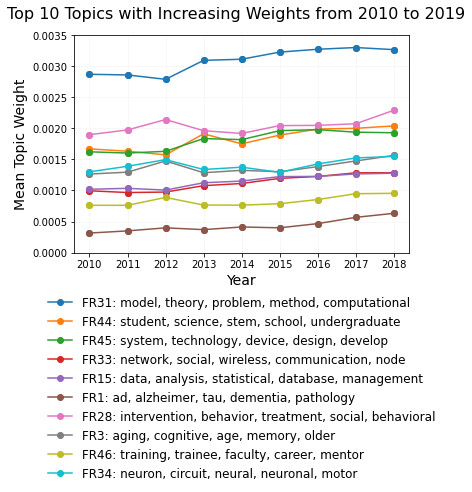

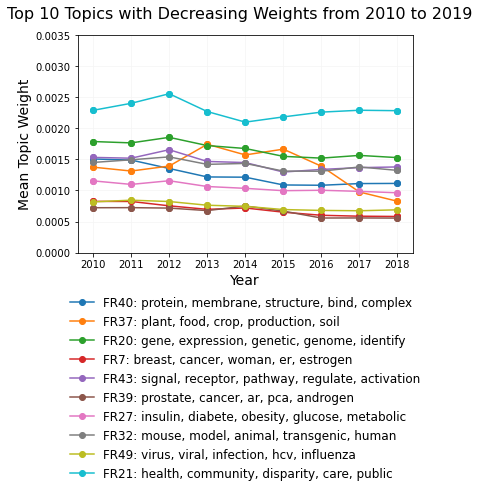

In [158]:
# Make Graphs

color_list = plt.rcParams['axes.prop_cycle'].by_key()['color']

linestyle_tuple = [
     (0, (1, 10)),
     (0, (1, 1)),

     (0, (5, 10)),
     (0, (5, 5)),
     (0, (5, 1)),

     (0, (3, 10, 1, 10)),
     (0, (3, 5, 1, 5)),
     (0, (3, 1, 1, 1)),

     (0, (3, 5, 1, 5, 1, 5)),
     (0, (3, 10, 1, 10, 1, 10)),
     (0, (3, 1, 1, 1, 1, 1))]

line_return = []
fig = plt.figure()
fig.suptitle('Top 10 Topics with Increasing Weights from 2010 to '+str(end_year), fontsize=16)
ax = fig.add_subplot(111)
plt.grid(True, color = "whitesmoke")
line = [[(0, 0)]]
i = 0
for n in top_slopes.index:
    zorder = 10
    color = color_list[i] # "#D3D3D3"   
    if i == 0:
        zorder = 10 #20
        color = color_list[i];
    #linear_fit = lm().fit(topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019.iloc[:,n].values.reshape(-1,1))
    #ax.plot(topic_wts_2010_2019["START_YEAR"], (topic_wts_2010_2019["START_YEAR"]*linear_fit.coef_[0][0])+linear_fit.intercept_,linestyle = 'dashed', color = color_list[i])
    ax.plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,n+1], '-o', color = color, zorder = zorder)
    #ax.plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,n+1], '-o', color = color, zorder = zorder, linestyle=linestyle_tuple[i])
    ax.errorbar(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,n+1], 
            yerr = np.array(topic_wts_se_2010_2019.iloc[:,n+1]), fmt = 'o', color = color, zorder = zorder)
    #line_return.append(mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=[color_list[i],color_list[i]]))
    line_return.append(mcol.LineCollection(line, linestyles=['solid'], colors=[color]))
    #line_return.append(mcol.LineCollection(line, linestyles=linestyle_tuple, colors=[color]))
    i+=1
    #leg.append("Topic %d"%(n+1))

plt.xticks(np.arange(topic_wts_2010_2019["START_YEAR"].min(), topic_wts_2010_2019["START_YEAR"].max()+1, 1.0))
plt.xlabel('Year', fontsize=14)
plt.ylabel('Mean Topic Weight', fontsize=14)
plt.ylim(bottom = 0, top = 0.0035)
#ax.yaxis.set_label_coords(-0.14,0.5)

# set up the proxy artist
lc = mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=['blue','blue'])
lc2 = mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=['orange','orange'])
# create the legend
#plt.legend(line_return, [leg[x-1] for x in top_slopes], handler_map={type(line_return[0]): HandlerDashedLines()},
#          handlelength=2, handleheight=2,bbox_to_anchor=(1.05, 0.7, 0.3, 0.2), loc='upper left')

plt.legend([top_leg_label[x] for x in range(0,len(top_leg_label))], bbox_to_anchor=(0.35, -0.35, 0.3, 0.2), 
           loc='upper center', fontsize = 'large', frameon = False)
plt.savefig("et_paper/full_increasing_"+str(num_topics)+"_topics_"+str(end_year)+".pdf", dpi = 800, bbox_inches = "tight")
plt.show()


#Make Graphs
#leg = []

#bottom_slopes.reverse()  # so the plot legend has the coldest listed first

line_return = []
fig = plt.figure()
fig.suptitle('Top 10 Topics with Decreasing Weights from 2010 to '+str(2019), fontsize=16)
ax = fig.add_subplot(111)
plt.grid(True, color = "whitesmoke")
i = 0
for n in bottom_slopes.index:
    zorder = 10
    color = color_list[i]  #"#D3D3D3"  
    if i == 4:
        zorder = 10 #20
        color = color_list[i]
    #linear_fit = lm().fit(topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019.iloc[:,n].values.reshape(-1,1))
    #ax.plot(topic_wts_2010_2019["START_YEAR"], (topic_wts_2010_2019["START_YEAR"]*linear_fit.coef_[0][0])+linear_fit.intercept_,linestyle = 'dashed', color = color_list[i+5])
    ax.plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,n+1], '-o', color=color, zorder = zorder)
    #ax.plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,n+1], '-o', color=color, zorder = zorder, linestyle=linestyle_tuple[i])
    ax.errorbar(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,n+1], 
            yerr = np.array(topic_wts_se_2010_2019.iloc[:,n+1]), fmt = 'o', color=color, zorder = zorder)
    #line_return.append(mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=[color_list[i+5],color_list[i+5]]))
    line_return.append(mcol.LineCollection(line, linestyles=['solid'], colors=[color]))
    #line_return.append(mcol.LineCollection(line, linestyles=linestyle_tuple, colors=[color]))
    i+=1
    #leg.append("Topic %d"%(n+1))

plt.xticks(np.arange(topic_wts_2010_2019["START_YEAR"].min(), topic_wts_2010_2019["START_YEAR"].max()+1, 1.0))
plt.xlabel('Year', fontsize=14)
plt.ylabel('Mean Topic Weight', fontsize=14)
plt.ylim(bottom = 0, top = 0.0035)
#ax.yaxis.set_label_coords(-0.14,0.5)


# set up the proxy artist
lc = mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=['blue','blue'])
lc2 = mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=['orange','orange'])

# create the legend
#plt.legend(line_return, [leg[x-1] for x in bottom_slopes], handler_map={type(line_return[0]): HandlerDashedLines()},
#          handlelength=2, handleheight=2,bbox_to_anchor=(1.05, 0.7, 0.3, 0.2), loc='upper left')

plt.legend([bottom_leg_label[x] for x in range(0,len(bottom_leg_label))], bbox_to_anchor=(0.35, -0.35, 0.3, 0.2), 
           loc='upper center', fontsize = 'large', frameon = False)
plt.savefig("et_paper/full_decreasing_"+str(50)+"_topics_"+str(2019)+".pdf", dpi = 800, bbox_inches = "tight")
plt.show()


## Plot for each topic in a grid

In [ ]:
sorted_slopes = regression_res.sort_values('Slope', ascending = False)

In [ ]:
leg_topic_label = sorted_slopes['Topic Label'].tolist()
leg = sorted_slopes['Topic Words'].tolist()
topic_n = sorted_slopes['n'].tolist()
leg_label = [i + ": " + j for i, j in zip(leg_topic_label, leg)]

In [ ]:
# set up grid
fig, ax = plt.subplots(5, 5, sharex = True, sharey = True, figsize=(16,14))
plt.ylim(bottom = 0, top = 0.004)

# create plot in each grid square
for count,col_idx in enumerate(sorted_slopes.iloc[0:25].index):
    
    #col = topic_wts_2010_2019.columns[col_idx]
    
    # map count to i,j in grid
    i = count // 5
    j = count % 5
    
    linear_fit = lm().fit(
        topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019.iloc[:,(col_idx+1)].values.reshape(-1,1))
    
    # set color of regression line based on 'hot' or 'cold'
    if(linear_fit.coef_[0][0] > 0): # hot
        reg_line_color = '#ff7f0e'
    else: # cold
        reg_line_color = 'blue'
    
    #ax[i,j].plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019[col], '-o', color = '#1f77b4')

    ax[i,j].errorbar(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,(col_idx+1)], 
            yerr = np.array(topic_wts_se_2010_2019.iloc[:,(col_idx+1)]), fmt = '-o', color = 'gray', zorder = 10) 
    
    ax[i,j].plot(topic_wts_2010_2019["START_YEAR"], \
        (topic_wts_2010_2019["START_YEAR"]*linear_fit.coef_[0][0])+linear_fit.intercept_, \
        linestyle = 'dashed', color = reg_line_color, zorder = 20)
    
    ax[i,j].grid(color = "whitesmoke")

    # put legend on two lines for topics 2, 28
    #if count == 0:
    #    ax[i,j].set_title('administrative, scientific, meeting, \n coordinate, management', \
    #                      fontsize = 8)
    #else:
    #    ax[i,j].set_title(leg[col_idx-1], fontsize = 8)
    
    ax[i,j].set_title(leg[count], fontsize = 8)
    
    # add topic number to each plot
    #ax[i,j].text(0.08, 0.85, str(count+1), horizontalalignment='center', verticalalignment='center', \
    #             transform=ax[i,j].transAxes, fontsize = 14)
    #ax[i,j].text(0.08, 0.90, str(col_idx), horizontalalignment='center', verticalalignment='center', \
    #         transform=ax[i,j].transAxes, fontsize = 14)
    ax[i,j].text(0.1, 0.90, leg_topic_label[count], horizontalalignment='center', verticalalignment='center', \
         transform=ax[i,j].transAxes, fontsize = 14)
    
    # add number of documents including topic to each plot - should this be dominant topic only? or some threshold?
    ax[i,j].text(0.65, 0.90, "n = " + str(topic_n[count]), horizontalalignment='center', verticalalignment='center', \
                 transform=ax[i,j].transAxes, fontsize = 14)
    
fig.suptitle('Full Corpus Topic Trends from 2010 to 2019 (Part 1)', fontsize = 16)
fig.text(0.5, -0.002, 'Year', ha='center', va='center', fontsize = 14)
fig.text(-0.002, 0.5, 'Mean Topic Weight', ha='center', va='center', rotation='vertical', fontsize = 14)
fig.tight_layout()
fig.subplots_adjust(top=0.93)

#plt.savefig("full_50_topic_trends_2018_part1.png", dpi = 800, bbox_inches = "tight")
plt.show()



In [ ]:
# set up grid
fig, ax = plt.subplots(5, 5, sharex = True, sharey = True, figsize=(16,14))
plt.ylim(bottom = 0, top = 0.004)

# create plot in each grid square
for count,col_idx in enumerate(sorted_slopes.iloc[25:50].index):
    
    #col = topic_wts_2010_2019.columns[col_idx]
    
    # map count to i,j in grid
    i = count // 5
    j = count % 5
    
    linear_fit = lm().fit(
        topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019.iloc[:,(col_idx+1)].values.reshape(-1,1))
    
    # set color of regression line based on 'hot' or 'cold'
    if(linear_fit.coef_[0][0] > 0): # hot
        reg_line_color = '#ff7f0e'
    else: # cold
        reg_line_color = 'blue'
    
    #ax[i,j].plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019[col], '-o', color = '#1f77b4')

    ax[i,j].errorbar(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,(col_idx+1)], 
            yerr = np.array(topic_wts_se_2010_2019.iloc[:,(col_idx+1)]), fmt = '-o', color = 'gray', zorder = 10) 
    
    ax[i,j].plot(topic_wts_2010_2019["START_YEAR"], \
        (topic_wts_2010_2019["START_YEAR"]*linear_fit.coef_[0][0])+linear_fit.intercept_, \
        linestyle = 'dashed', color = reg_line_color, zorder = 20)
    
    ax[i,j].grid(color = "whitesmoke")

    # put legend on two lines for topics 2, 28
    #if count == 0:
    #    ax[i,j].set_title('administrative, scientific, meeting, \n coordinate, management', \
    #                      fontsize = 8)
    #else:
    #    ax[i,j].set_title(leg[col_idx-1], fontsize = 8)
    
    ax[i,j].set_title(leg[count+25], fontsize = 8)
    
    # add topic number to each plot
    #ax[i,j].text(0.08, 0.85, str(count+1), horizontalalignment='center', verticalalignment='center', \
    #             transform=ax[i,j].transAxes, fontsize = 14)
    #ax[i,j].text(0.08, 0.90, str(col_idx), horizontalalignment='center', verticalalignment='center', \
    #         transform=ax[i,j].transAxes, fontsize = 14)
    ax[i,j].text(0.1, 0.90, leg_topic_label[count+25], horizontalalignment='center', verticalalignment='center', \
         transform=ax[i,j].transAxes, fontsize = 14)
    
    # add number of documents including topic to each plot - should this be dominant topic only? or some threshold?
    ax[i,j].text(0.65, 0.90, "n = " + str(topic_n[count+25]), horizontalalignment='center', verticalalignment='center', \
                 transform=ax[i,j].transAxes, fontsize = 14)
    
fig.suptitle('Full Corpus Topic Trends from 2010 to 2019 (Part 2)', fontsize = 16)
fig.text(0.5, -0.002, 'Year', ha='center', va='center', fontsize = 14)
fig.text(-0.002, 0.5, 'Mean Topic Weight', ha='center', va='center', rotation='vertical', fontsize = 14)
fig.tight_layout()
fig.subplots_adjust(top=0.93)

#plt.savefig("full_50_topic_trends_2018_part2.png", dpi = 800, bbox_inches = "tight")
plt.show()